# Renishaw inVia Raman Code

Code to process Renishaw inVia Raman spectra exported as .txt

In [1]:
# import modules
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
from matplotlib import rcParams
import matplotlib.cm as cm
import math
import numpy as np
import pandas as pd
import os
import chart_studio.plotly as py
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
from pylab import *
from BaselineRemoval import BaselineRemoval

%matplotlib inline

# specify sample path and export path
sample_folder = r'C:\Users\tl457\OneDrive - University Of Cambridge 1\1_Data\220301-Raman'
export_folder = r'C:\Users\tl457\OneDrive - University Of Cambridge 1\1_Data\220301-Raman'

# specify matplotlib configuration file name
rc_fname = r'C:\Users\tl457\Documents\GitHub\spectroscopy\plotting_params.txt'

# define functions
def find_nearest_wav(wav_array, wavelength):
    """Function to find the nearest wavelength to the wavelength specified (float)
	Args:
		  wav_array being an array of wavelengths
            wavelength representing the wavelength you wish to search for
	Returns:
		Float: closest wavelength in wav_array
		"""
    idx = np.searchsorted(wav_array, wavelength, side="left")
    if idx > 0 and (idx == len(wav_array) or math.fabs(wavelength - wav_array[idx-1]) < math.fabs(wavelength - wav_array[idx])):
        return wav_array[idx-1]
    else:
        return wav_array[idx]

In [2]:
# specify sample filenames
fn={}
fn[0]='Acrylate_WEL_offchan_P5p0_t10s_a70_1800g1.txt'
fn[1]='Acrylate_WEL_P5p0_t10s_a70_1800g.txt'

# create DataFrames
data={}
for i in fn:
    temp=pd.read_csv(os.path.join(sample_folder,fn[i]),sep='\t',skiprows=1,names=['Wavenumber','Intensity'],index_col=0)
    temp=temp.sort_index()
    data[i]=temp

# create list of colours for plots from list of samples
evenly_spaced_interval = np.linspace(0, 1, len(fn))
colors = [cm.jet(x) for x in evenly_spaced_interval]

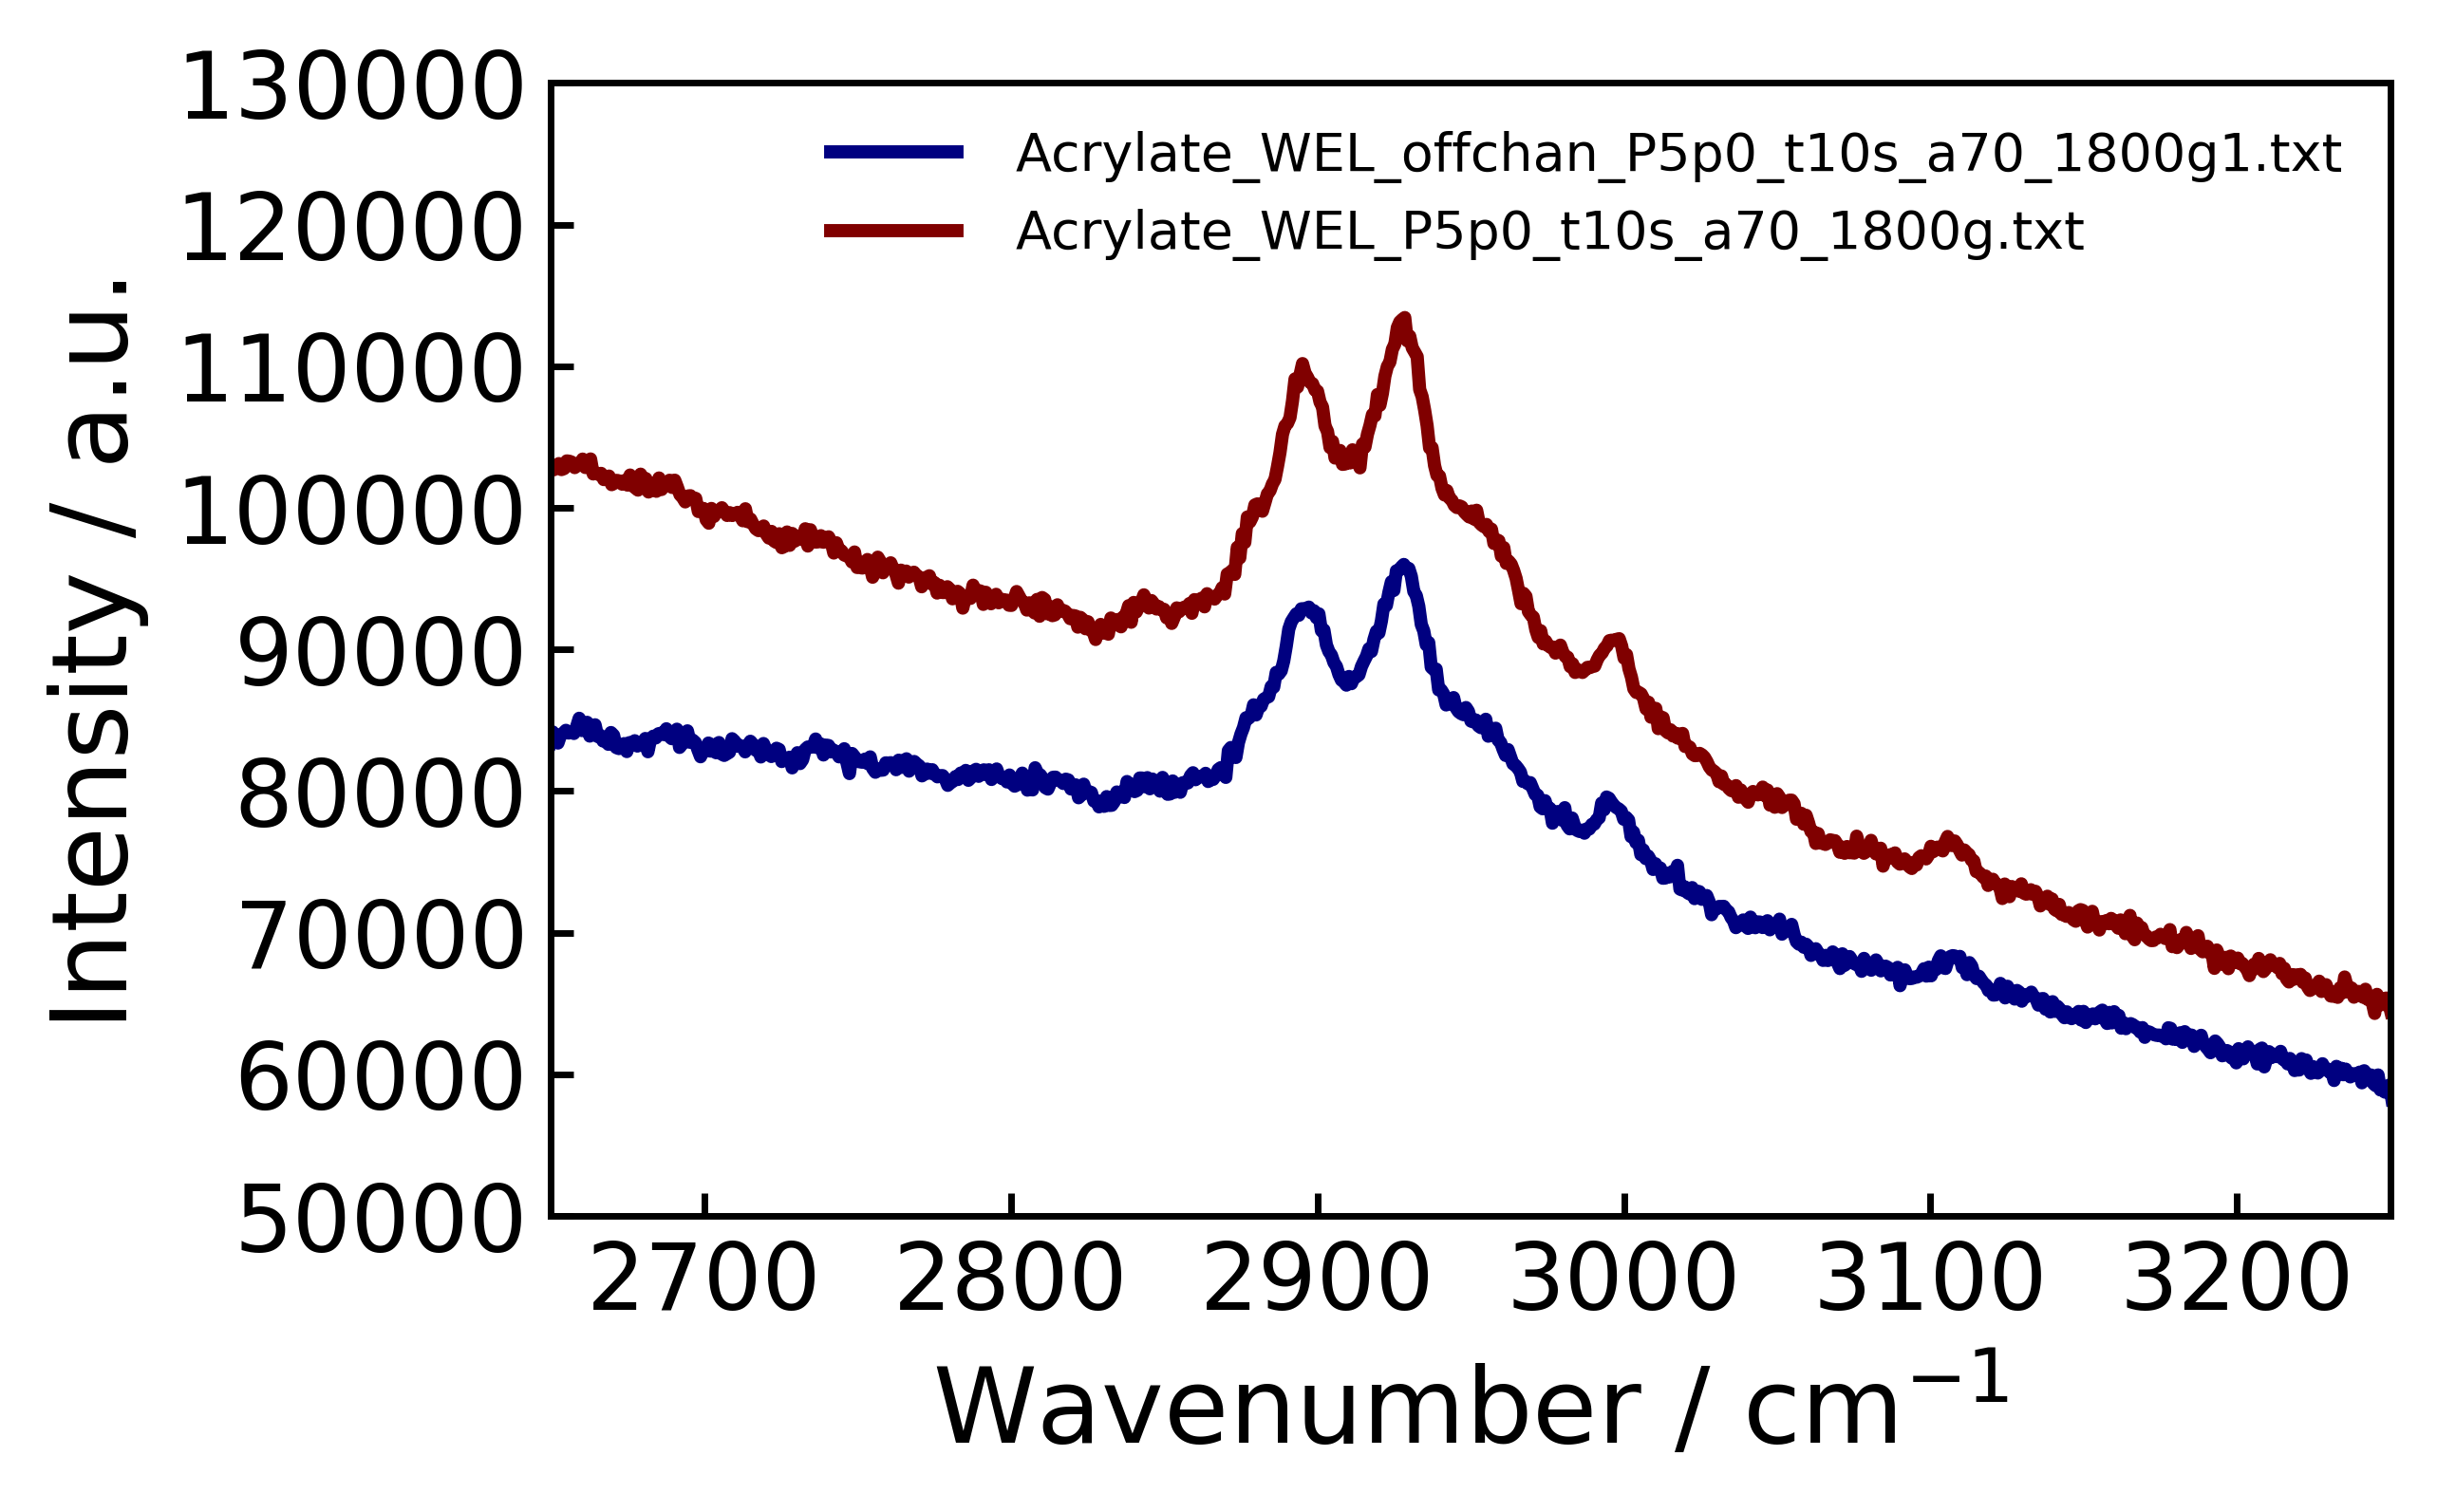

In [3]:
# plot raw data
with rc_context(fname=rc_fname):
    for i in fn:
        plt.plot(data[i],color=colors[i],label=fn[i])
    plt.xlim(2650,3250)
    plt.ylim(50000,130000)
    plt.xlabel('Wavenumber / cm$^{-1}$')
    plt.ylabel('Intensity / a.u.')
    plt.legend(fontsize=8)

In [4]:
# specify SG filter and baseline correction parameters
sav_gol_order=3 # SG filtering applied to reduce noise
sav_gol_window=25 # SG filtering applied to reduce noise
wav_lower_limit=2750
wav_upper_limit=3150

# find closest wavenumbers to wavenumber limits
wav_index_lower=[]
wav_index_upper=[]
for i in fn:
    wav_index_lower.append(find_nearest_wav(data[i].index,wav_lower_limit))
    wav_index_upper.append(find_nearest_wav(data[i].index,wav_upper_limit))

# reduce DataFrame size based on wavenumber limits
data_red={}
for i in fn:
    temp=data[i]
    data_red[i]=temp.loc[(temp.index > wav_index_lower[i]) & (temp.index < wav_index_upper[i])]

# apply baseline removal, normalisation and SG filtering routines
data_fitted=[]
data_fitted_SG=[]
for i in fn:
    temp=data_red[i]
    baseObj=BaselineRemoval(temp['Intensity'])
    z=baseObj.ModPoly(3)
    n=np.linalg.norm(z)
    z_filter=savgol_filter(z, sav_gol_window, sav_gol_order)
    data_fitted.append(pd.Series(data=z/n,index=temp.index,name=fn[i]))
    data_fitted_SG.append(pd.Series(data=z_filter/n,index=temp.index,name=fn[i]))

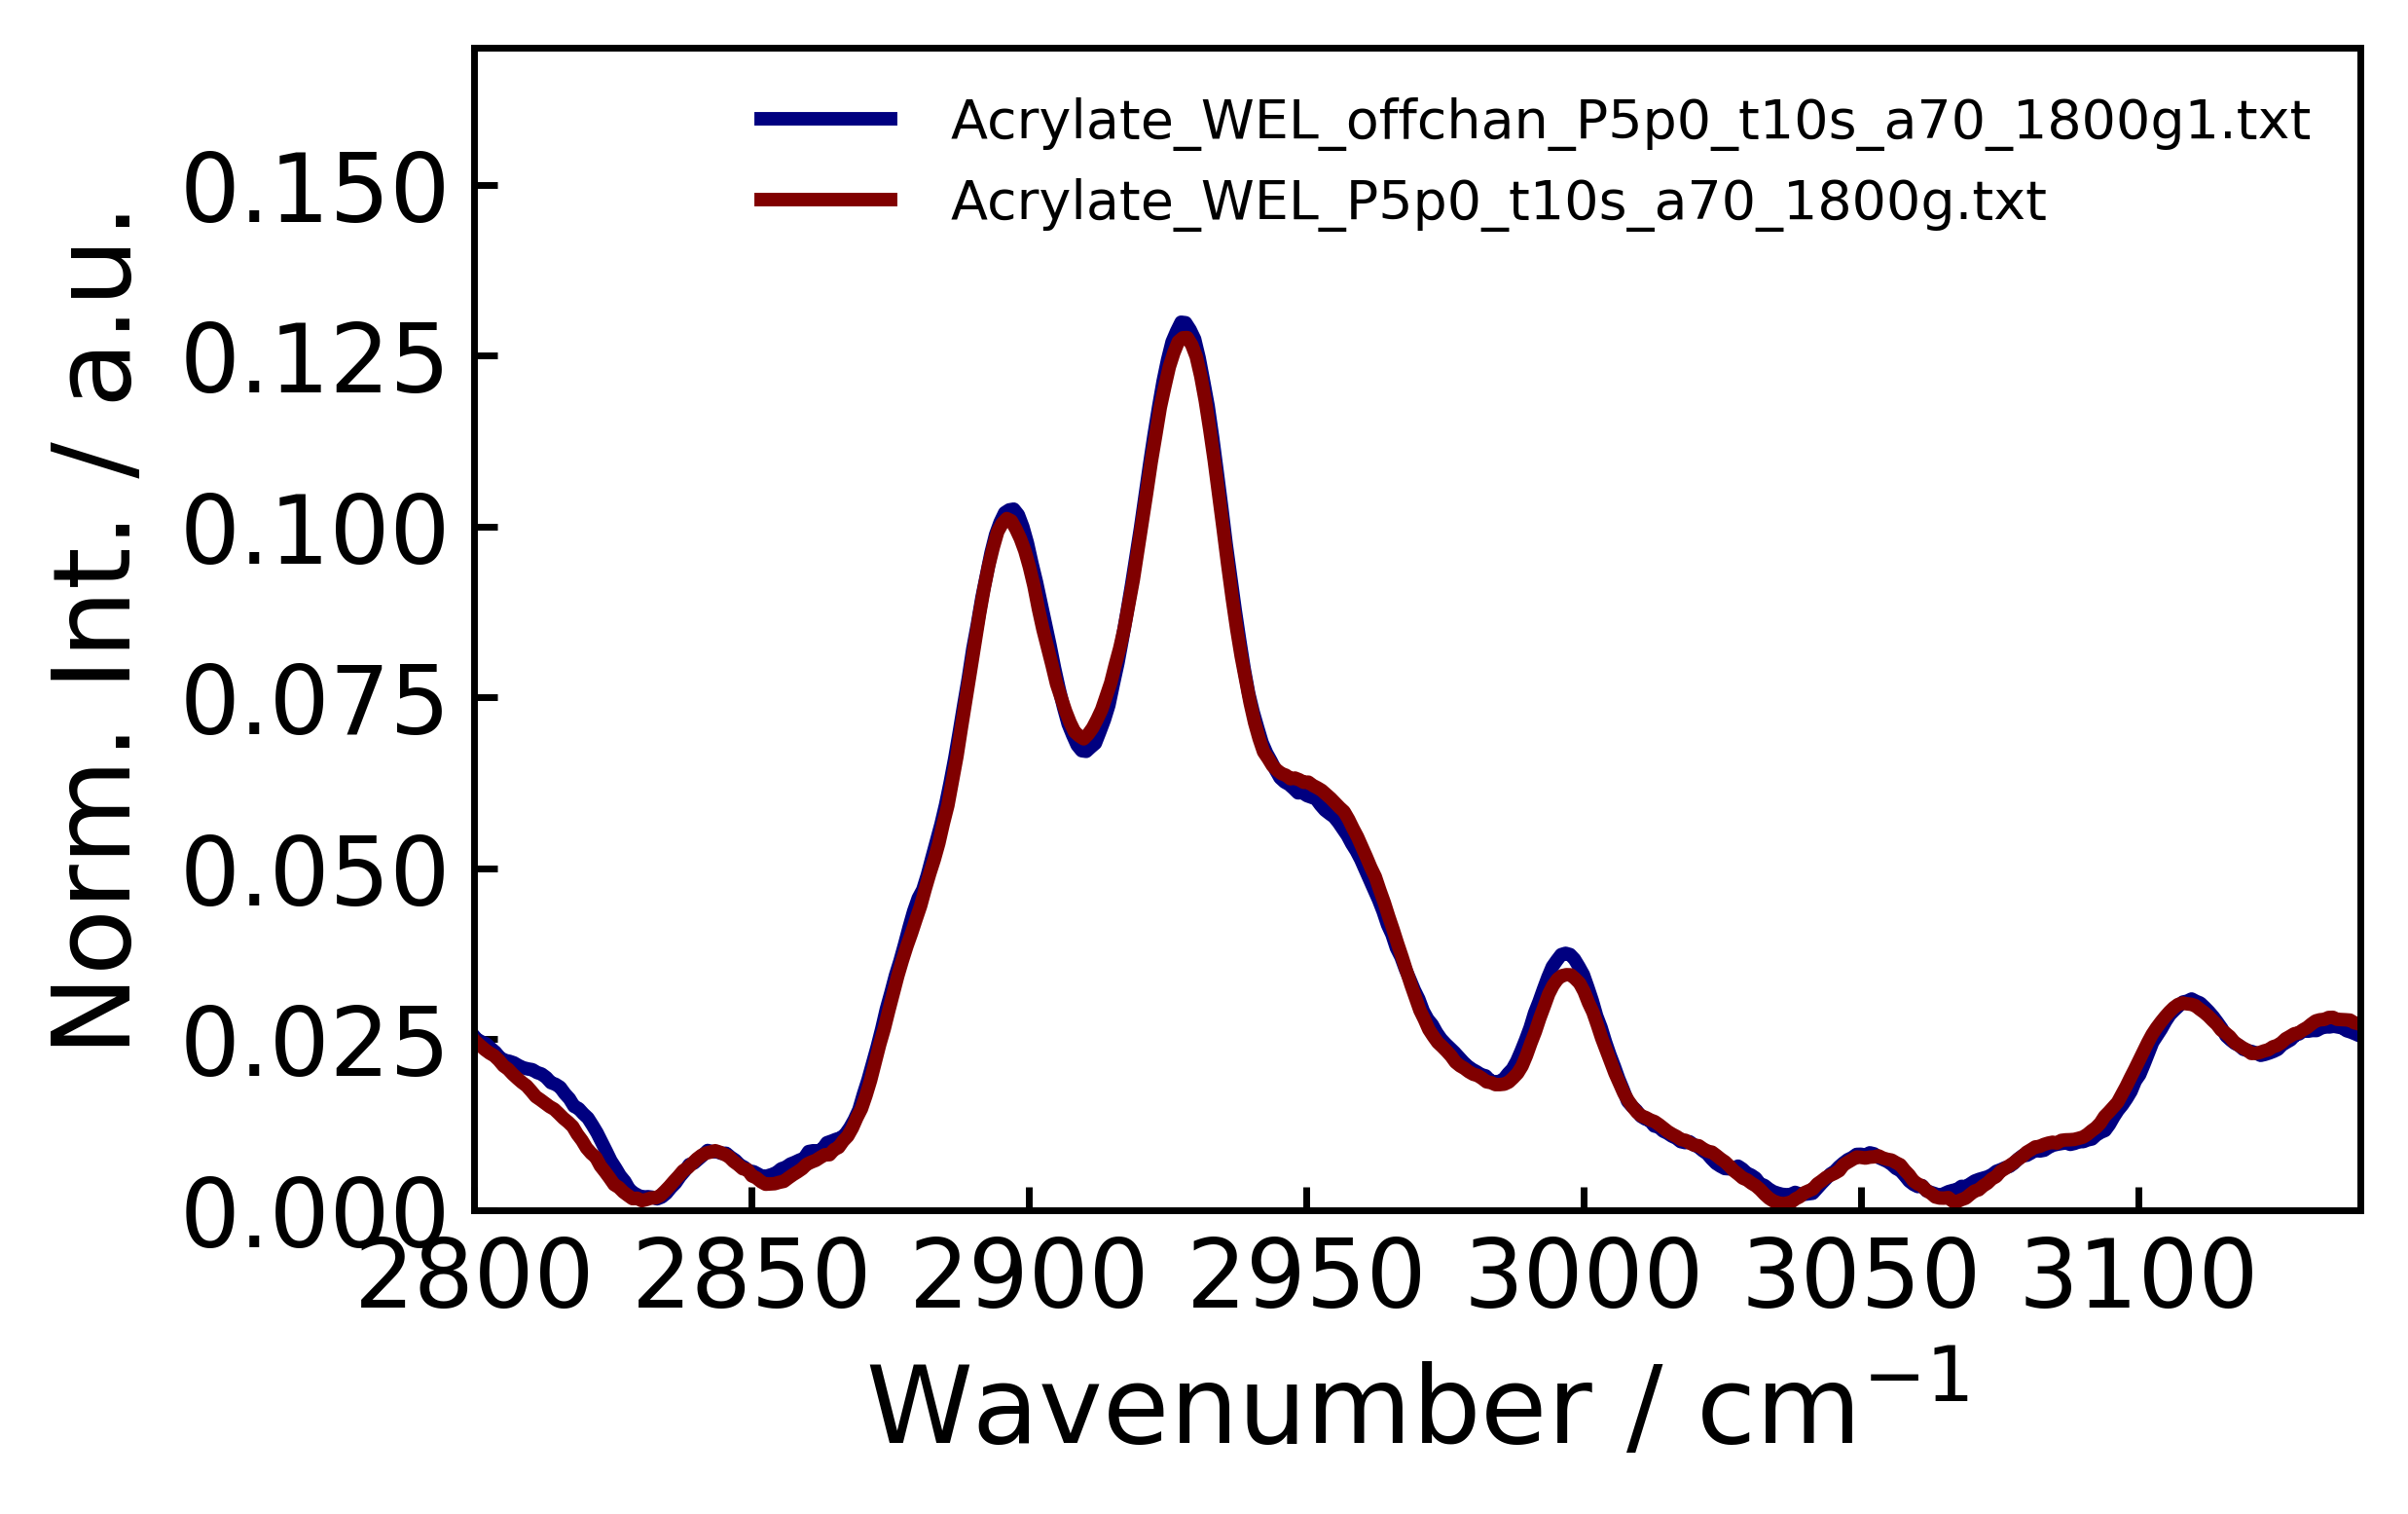

In [5]:
# plot processed spectra
with rc_context(fname=rc_fname):
    for i in fn:
        plt.plot(data_fitted_SG[i],color=colors[i],label=fn[i])
    plt.ylim(0,0.17)
    plt.xlim(wav_lower_limit+50,wav_upper_limit-10)
    plt.xlabel('Wavenumber / cm$^{-1}$')
    plt.ylabel('Norm. Int. / a.u.')
    plt.legend(fontsize=8)
    #plt.savefig(os.path.join(export_folder,'raman_plot.png'))